In [2]:
import pandas as pd
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

# Load data
url = 'https://raw.githubusercontent.com/DyanelLancea/Airline-Review-Sentiement-Analysis/refs/heads/master/airlines_review.csv'
df = pd.read_csv(url, index_col=0)

# List of special characters to remove
removechar = [ '@', '#', '$', '%', '^', '&', '*', '(', ')',
               '-', '_', '=', '+', '{', '}', '[', ']', '|',
               '\\', ':', ';', '"', "'", '<', '>', ',',
                 '/', '~', '`', '✅ Trip Verified', 'Not Verified', 'Â Â']

# Remove duplicates
df = df.drop_duplicates()

# Replace missing values with NA or Unknown function
def replace_missing_value(df):
    for col in df.columns:
        if df[col].dtype == 'O':  # Object type (string)
            df[col] = df[col].fillna('Unknown')
        else:
            df[col] = df[col].fillna("NA")
    return 

# Remove special characters from specific columns function
def remove_special_characters(df, removechar, char):
    for char in removechar:
        df['Airlines'] = df['Airlines'].str.replace(char, ' ', regex=False)
        df['Text Content'] = df['Text Content'].str.replace(char, '', regex=False)
    return df

# Apply data cleaning functions
replace_missing_value(df)
remove_special_characters(df, removechar, char='')

# Standardize text case
df['Airlines'] = df['Airlines'].str.title()
df['Name'] = df['Name'].str.title()
df['Text Content'] = df['Text Content'].str.lower()

# Remove leading spaces from the 'Name' column
df['Airlines'] = df['Airlines'].str.lstrip()
df['Name'] = df['Name'].str.lstrip()
df['Date Published'] = df['Date Published'].str.lstrip()
df['Text Content'] = df['Text Content'].str.lstrip()

# Save cleaned data to a new CSV file
df.to_csv('airlines_review_cleaned.csv', index=False)

# Display the cleaned DataFrame
print(df)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\daryl\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\daryl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


              Airlines             Name Date Published  \
0        Qatar Airways     Romana Malik     2025-09-07   
1        Qatar Airways           J Raiz     2025-09-02   
2        Qatar Airways       Iman Yusuf     2025-09-01   
3        Qatar Airways     Ronald Zwart     2025-08-26   
4        Qatar Airways  Dmitriy Berezin     2025-08-21   
...                ...              ...            ...   
14586  Hainan Airlines        J Depaepe     2010-01-19   
14587  Hainan Airlines  Pieter D'Hamers     2010-01-10   
14588  Hainan Airlines           Y Chen     2010-01-09   
14589  Hainan Airlines          A Smith     2009-12-16   
14590  Hainan Airlines    Richard Borst     2009-12-11   

                                            Text Content  
0      we choose our seats when booking and they chan...  
1      initially i was supposed to be traveling with ...  
2      i want to sincerely thank qatar airways for th...  
3      boarding was efficient friendly personable wel...  
4      w

### Function to read and parse the AFINN lexicon, then loads it into a dictionary (afinn_dict)

In [3]:
import requests

def load_afinn_lexicon(afinn_url):
    afinn_dict = {} # initialise an empty dictionary to hold the AFINN lexicon
    response = requests.get(afinn_url)  # download the file
    try:
        for line in response.text.splitlines():
            line = line.strip()
            if not line: # checks for and skips any empty lines in the file
                continue
            word, score = line.rsplit('\t', 1) # splits the line into two parts
            afinn_dict[word] = int(score) # adds the word and its score to the dict
    except FileNotFoundError:
        print(f"File not found: {afinn_url}")
    return afinn_dict


### Load the AFINN lexicon (provided sentiment dictionary) then print a sample of it

In [4]:
afinn_url = "https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt"
afinn_dict = load_afinn_lexicon(afinn_url)

print("AFINN dictionary loaded. Sample entries:")
print(list(afinn_dict.items())[:10])  # show first 10 words and scores


AFINN dictionary loaded. Sample entries:
[('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)]


### Function for sentence tokanization 
This function takes some text and returns a list of sentences. If you don’t give it a string, it safely returns an empty list instead of crashing.

In [5]:
def tokenize_sentences(text):
    if not isinstance(text, str):
        return []
    return nltk.tokenize.sent_tokenize(text)

### Function to calculate sentiment and normalization

In [6]:
def calculate_sentiment_score(sentences, afinn_dict):
    score = 0
    words = sentences.lower().split()    # breaks down the sentence into individual words
    for word in words:  # goes through each word in the list 
        score += afinn_dict.get(word, 0)    # looks up each word and adds the score
    return score

def normalize_score(score, text_length):
    if text_length == 0:    # sentences with no words will return a score of 0 (preventing an error of dividing by zero)
        return 0
    # normalization to get a score per word, then clamping to [-1, 1]
    normalized = score / text_length    # calculates the average score per word
    return max(-1.0, min(1.0, normalized))  
    # makes sure the score doesn't go over 1.0 and below -1.0. 
    # (if the score is -2.5, this will return -1.0)

### Function to find the extreme sentences

In [7]:
def find_extreme_sentences(sentences, afinn_dict):
    
    if not sentences:   # to prevent errors if the list is empty
        return None, None

    # initialises an empty list to hold sentences and their scores
    scored_sentences = []
    for sent in sentences:
        score = calculate_sentiment_score(sent, afinn_dict)     # uses the sentiment score function
        normalized_score = normalize_score(score, len(sent.split()))    # uses the normalization function
        scored_sentences.append({'sentence': sent, 'score': normalized_score})

    # find the sentences with max and min normalized scores
    most_positive = max(scored_sentences, key=lambda x: x['score'])
    most_negative = min(scored_sentences, key=lambda x: x['score'])
    
    return most_positive, most_negative

### Sliding Window Function to find the most positive and negative paragraphs.

Using a window size lets us "slide" a focus area over the text. The window's score changes as it moves, so it can detect specific pockets of strong emotion(positive/negative).

When the window is over a section with very positive sentences, it will get a high score. When it slides over the negative section, it will get a very low score.

This give us a much more detailed and accurate picture of the sentiment throughout the text. It helps us pinpoint exactly where the most positive and negative opinions are located, rather than just getting a single, overall average.

In [8]:
def sliding_window_analysis(sentences, afinn_dict, window_size=3):
    # window size is how many sentences to include in each paragraph which is 3
    
    if len(sentences) < window_size:    # checks if enough sentences exists
        return None, None
    
    # initialises an empty list to hold sentences and their scores
    scored_windows = []
    for i in range(len(sentences) - window_size + 1):    # slides the window across the sentences
        window = sentences[i:i + window_size]
        paragraph_text = ' '.join(window)
        
        # calculate score for the paragraph window
        score = calculate_sentiment_score(paragraph_text, afinn_dict)   # uses the sentiment score function
        normalized_score = normalize_score(score, len(paragraph_text.split()))  # uses the normalization function

        # qdds a dictionary with two things: the paragraph text and its normalized score
        scored_windows.append({'paragraph': paragraph_text, 'score': normalized_score})

    # find the paragraphs with max and min scores
    most_positive_paragraph = max(scored_windows, key=lambda x: x['score'])
    most_negative_paragraph = min(scored_windows, key=lambda x: x['score'])
    
    return most_positive_paragraph, most_negative_paragraph

Applying functions into Dataframe

In [9]:
#Apply tonkenize function into Dataframe
df['Text Content Tokenized'] = df['Text Content'].apply(tokenize_sentences)
#Apply Sentiment scoring function into Dataframe
df['Sentiment Score'] = df.apply(lambda x: calculate_sentiment_score(x['Text Content'],afinn_dict), axis=1)
#Apply normalize function to Dataframe
df['Normalized Sentiment Score'] = df.apply(lambda x: normalize_score(x['Sentiment Score'],len(x["Text Content"].split())), axis=1)
#Apply finding extreme sentences function to Dataframe
df['Extreme Senctences'] = df.apply(lambda x: find_extreme_sentences(x['Text Content Tokenized'],afinn_dict), axis=1)
#Creating Columns for Most and Least Extreme Sentences
df['Most Positive Senctence'] = df['Extreme Senctences'].apply(lambda x: x[0]['sentence'])
df['Most Positive Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[0]['score'])
df['Most Negative Senctence'] = df['Extreme Senctences'].apply(lambda x: x[1]['sentence'])
df['Most Negative Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[1]['score'])

Results and Visualisations

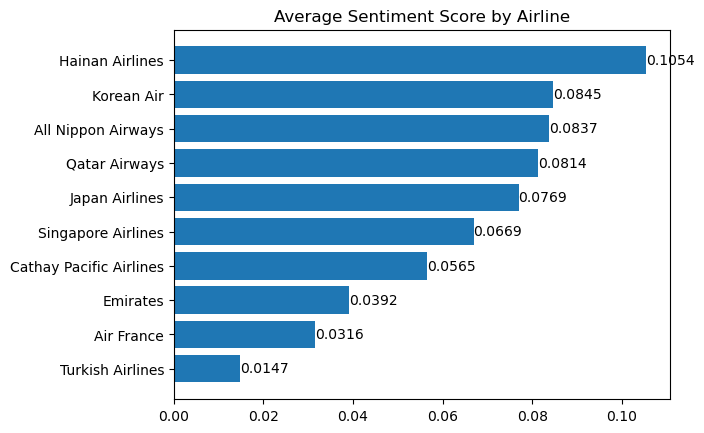

In [92]:
import matplotlib.pyplot as plt
df_mean =  df.groupby('Airlines')['Normalized Sentiment Score'].agg('mean').sort_values() 

fig, ax = plt.subplots()

bx = ax.barh(df_mean.index, df_mean.values,label=df_mean.values)
ax.bar_label(bx, fmt='%.4f')

ax.set_title('Average Sentiment Score by Airline')



plt.show()

Text(0.5, 1.0, 'Boxplot of Sentment Scores by Airline')

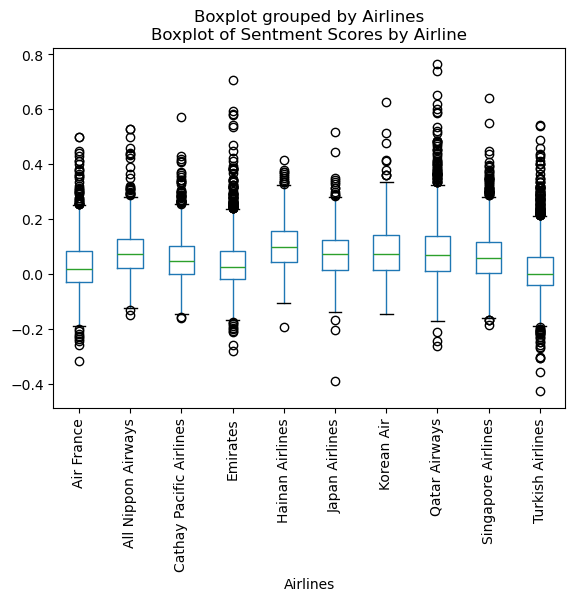

In [ ]:
ax = df.boxplot(column='Normalized Sentiment Score',by='Airlines',rot=90,grid=False)
ax.set_title('Boxplot of Sentment Scores by Airline')
#sdasd

In [136]:
df['year'] = pd.DatetimeIndex(df['Date Published']).year
df['month'] = pd.DatetimeIndex(df['Date Published']).month
data = df.groupby(by=['Airlines', 'year'])['Normalized Sentiment Score'].mean()
import seaborn as sns

sns.lineplot(data=data, x="year", y="Normalized Sentiment Score", hue="Airlines", markers=True)

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

,Airlines,Name,Date Published,Text Content,Text Content Tokenized,Sentiment Score,Normalized Sentiment Score,Extreme Senctences,Most Positive Senctence,Most Positive Senctence Score,Most Negative Senctence,Most Negative Senctence Score,year,month
0,Qatar Airways,Romana Malik,2025-09-07,we choose our seats when booking and they chan...,[we choose our seats when booking and they cha...,2,0.037037,({'sentence': 'fortunately we got the bulkhead...,fortunately we got the bulkhead seats we had s...,0.153846,we choose our seats when booking and they chan...,0.000000,2025,9
1,Qatar Airways,J Raiz,2025-09-02,initially i was supposed to be traveling with ...,[initially i was supposed to be traveling with...,7,0.106061,"({'sentence': 'i have been a loyal client.', '...",i have been a loyal client.,0.500000,initially i was supposed to be traveling with ...,-0.068966,2025,9
2,Qatar Airways,Iman Yusuf,2025-09-01,i want to sincerely thank qatar airways for th...,[i want to sincerely thank qatar airways for t...,12,0.137931,({'sentence': 'i want to sincerely thank qatar...,i want to sincerely thank qatar airways for th...,0.375000,while checking in at jeddah airport i couldn’t...,0.000000,2025,9
3,Qatar Airways,Ronald Zwart,2025-08-26,boarding was efficient friendly personable wel...,[boarding was efficient friendly personable we...,18,0.132353,({'sentence': 'boarding was efficient friendly...,boarding was efficient friendly personable wel...,0.444444,naturally the mandatory photo standing behind ...,-0.100000,2025,8
4,Qatar Airways,Dmitriy Berezin,2025-08-21,when booking the flight wa shown as a qsuite b...,[when booking the flight wa shown as a qsuite ...,-1,-0.018868,({'sentence': 'customer care has been unrespon...,customer care has been unresponsive after mult...,0.083333,when booking the flight wa shown as a qsuite b...,-0.057143,2025,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14586,Hainan Airlines,J Depaepe,2010-01-19,brupek business class. 6 hour delay in brussel...,"[brupek business class., 6 hour delay in bruss...",2,0.035088,({'sentence': 'new aircraft very personal serv...,new aircraft very personal service great food ...,0.300000,6 hour delay in brussels but flight was just p...,-0.100000,2010,1
14587,Hainan Airlines,Pieter D'Hamers,2010-01-10,brupekbru. new a330 good and friendly service....,"[brupekbru., new a330 good and friendly servic...",8,0.137931,({'sentence': 'new a330 good and friendly serv...,new a330 good and friendly service.,0.833333,brupekbru.,0.000000,2010,1
14588,Hainan Airlines,Y Chen,2010-01-09,beijingguangzhou b737800 in economy. despite t...,"[beijingguangzhou b737800 in economy., despite...",2,0.062500,({'sentence': 'excellent service by flight att...,excellent service by flight attendants as they...,0.300000,despite the 30 minute delay hna did well to in...,-0.058824,2010,1
14589,Hainan Airlines,A Smith,2009-12-16,xiy to ctu on boeing 737800 in economy. flight...,"[xiy to ctu on boeing 737800 in economy., flig...",4,0.045977,({'sentence': 'flight delayed one and a half h...,flight delayed one and a half hours due to wea...,0.090909,xiy to ctu on boeing 737800 in economy.,0.000000,2009,12
